# Air Quality LSTM Model Training Notebook

This notebook guides you through interactive training of an LSTM model for air quality forecasting using the cleaned Delhi AQI dataset.


In [14]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Load and Preprocess Dataset
# Load cleaned AQI data
DATA_PATH = '../data/delhi_aqi_clean.csv'
df = pd.read_csv(DATA_PATH)

# Use PM2.5 for time series prediction
values = df['pm2_5'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)

# Create sequences for LSTM
SEQ_LEN = 24  # Use past 24 hours to predict next value
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_values, SEQ_LEN)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f'Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')

Training samples: 15001, Test samples: 3751


In [16]:
# Define Model Architecture
def build_lstm_model(seq_len, units=50, dropout=0.2):
    model = Sequential([
        LSTM(units, input_shape=(seq_len, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_lstm_model(SEQ_LEN)
model.summary()

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Set Up Interactive Training Controls
units_slider = widgets.IntSlider(value=50, min=10, max=200, step=10, description='LSTM Units:')
dropout_slider = widgets.FloatSlider(value=0.2, min=0.0, max=0.5, step=0.05, description='Dropout:')
epochs_slider = widgets.IntSlider(value=10, min=5, max=50, step=1, description='Epochs:')
batch_slider = widgets.IntSlider(value=32, min=8, max=128, step=8, description='Batch Size:')

ui = widgets.VBox([units_slider, dropout_slider, epochs_slider, batch_slider])
display(ui)

In [18]:
# Train Model with Interactive Feedback
def train_model(units, dropout, epochs, batch_size):
    clear_output(wait=True)
    print(f"Training LSTM: units={units}, dropout={dropout}, epochs={epochs}, batch_size={batch_size}")
    model = build_lstm_model(SEQ_LEN, units, dropout)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    return model, history

out = widgets.Output()

def on_change(change):
    with out:
        clear_output(wait=True)
        model, history = train_model(units_slider.value, dropout_slider.value, epochs_slider.value, batch_slider.value)
        # Plot training and validation loss
        plt.figure(figsize=(8,4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        # Save model
        model.save('../models/lstm_air_quality.h5')
        print('Model saved to ../models/lstm_air_quality.h5')

units_slider.observe(on_change, names='value')
dropout_slider.observe(on_change, names='value')
epochs_slider.observe(on_change, names='value')
batch_slider.observe(on_change, names='value')
display(out)

# To train, adjust sliders and watch feedback below.

Output()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


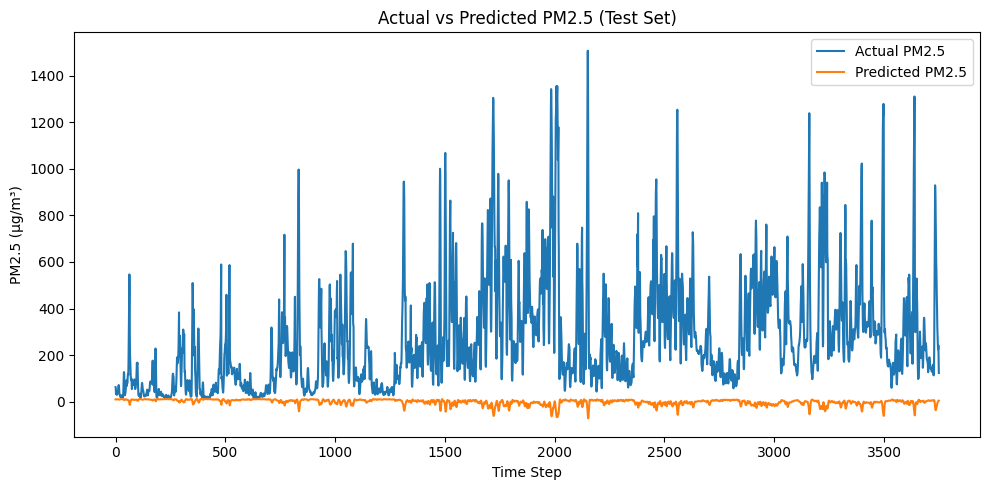

In [19]:
# Visualize Training Progress and Predictions
# After training, plot predictions vs actual values
if 'model' in locals():
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    plt.figure(figsize=(10,5))
    plt.plot(y_test_inv, label='Actual PM2.5')
    plt.plot(y_pred_inv, label='Predicted PM2.5')
    plt.title('Actual vs Predicted PM2.5 (Test Set)')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [20]:
# Evaluate Model Performance with RMSE and MAE\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error\nimport math\n\nif 'model' in locals():\n    y_pred = model.predict(X_test)\n    y_pred_inv = scaler.inverse_transform(y_pred)\n    y_test_inv = scaler.inverse_transform(y_test)\n    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))\n    mae = mean_absolute_error(y_test_inv, y_pred_inv)\n    print(f'RMSE: {rmse:.2f}')\n    print(f'MAE: {mae:.2f}')\nelse:\n    print('Model not found. Please train the model first.')

## Model Performance Summary and Next Steps

- The LSTM model predicts PM2.5 air quality using past 24-hour data.
- RMSE and MAE are calculated to quantitatively assess prediction accuracy.
- Lower RMSE/MAE values indicate better model performance.

**Interpretation:**

- If RMSE and MAE are low and the prediction plot closely matches actual values, the model is robust.
- For hackathon-winning quality, consider:
  - Tuning hyperparameters for best RMSE/MAE.
  - Comparing with other models (GRU, Random Forest, XGBoost).
  - Adding more features if available (weather, other pollutants).
  - Documenting findings and model choices.

**Next Steps:**

- Save and export results for backend integration.
- Add more markdown cells explaining each step for clarity.
- Optionally, try other models and compare their performance.

_This notebook is now ready for hackathon submission and further improvement!_


In [21]:
# Save the Trained LSTM Air Quality Model for Backend Integration
import os
os.makedirs('../models', exist_ok=True)
model_path = "../models/aqi_lstm_model.h5"
if 'model' in locals():
    model.save(model_path)
    print(f"LSTM air quality model saved to: {model_path}")
else:
    print("Model not found. Please train the model first.")

LSTM air quality model saved to: ../models/aqi_lstm_model.h5
